# Insurance Premium Price Predictor - Model building

#### Importing required modules

In [1]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
import logging
import pickle
import mlflow
import numpy as np
import pandas as pd
import shap
import optuna


#### Creating MLFlow Experiment

In [2]:
mlflow.set_experiment("Insurance Premium Prediction")

<Experiment: artifact_location='file:///Users/kvijayakumar/Documents/GitHub/health-insurance-premium-prediction/mlruns/481284435214831350', creation_time=1731178692714, experiment_id='481284435214831350', last_update_time=1731178692714, lifecycle_stage='active', name='Insurance Premium Prediction', tags={}>

#### Reading the data

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


#### Creating Feature Target split

In [5]:
#Preparing the data
X = df.drop(columns=['PremiumPrice'])
y = df['PremiumPrice']

**Standardizing for linear regression**

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries
0,0.233197,-0.850750,-0.938978,-0.243056,-0.469358,-1.306105,-1.399250,-0.523356,-0.365148,-0.891187
1,1.307981,1.175433,-0.938978,-0.243056,-0.469358,1.170852,-0.277062,-0.523356,-0.365148,-0.891187
2,-0.411674,1.175433,1.064988,-0.243056,-0.469358,-1.008870,-1.258976,-0.523356,-0.365148,0.444239
3,0.734763,1.175433,1.064988,-0.243056,2.130569,1.468086,1.125674,-0.523356,-0.365148,1.779665
4,-0.268369,-0.850750,-0.938978,-0.243056,2.130569,-0.216244,0.774990,-0.523356,-0.365148,0.444239


### Base model building (Linear Regression)

In [7]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)


In [8]:
with mlflow.start_run(run_name="LinearRegression"):
    model = LinearRegression()
    model.fit(X_scaled_train, y_train)

    y_pred = model.predict(X_scaled_train)
    train_metrics = {
        'train_r2': r2_score(y_train, y_pred),
        'train_mae': mean_absolute_error(y_train, y_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred)),
        'train_mape': np.mean(np.abs((y_train - y_pred) / y_train)) * 100
    }

    print("Baseline model train metrics")
    print(train_metrics)

    y_pred = model.predict(X_scaled_test)
    test_metrics = {
        'test_r2': r2_score(y_test, y_pred),
        'test_mae': mean_absolute_error(y_test, y_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'test_mape': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }

    print("Baseline model test metrics")
    print(test_metrics)

    with open("LinearRegression_model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.log_artifact("LinearRegression_model.pkl")
    mlflow.sklearn.log_model(model, "LinearRegression")
    mlflow.set_tag("model_type", "LinearRegression")

Baseline model train metrics
{'train_r2': 0.6219256563245064, 'train_mae': 2692.4716871413643, 'train_rmse': 3793.4572240024972, 'train_mape': 11.678689538341121}
Baseline model test metrics
{'test_r2': 0.7133944270278743, 'test_mae': 2586.2253840681055, 'test_rmse': 3495.9493282738235, 'test_mape': 10.962596602494685}


2024/11/10 04:10:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Tree based models

#### Creating methods for hyperparameter tuning with kfold validation

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def cross_validate_metrics(model, X, y, n_splits=5):
    # Set up KFold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize metric lists
    r2_scores, mae_scores, rmse_scores, mape_scores = [], [], [], []

    # Cross-validate and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Append metrics
        r2_scores.append(r2_score(y_val, y_pred))
        mae_scores.append(mean_absolute_error(y_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        mape_scores.append(np.mean(np.abs((y_val - y_pred) / y_val)) * 100)

    # Compute average scores across folds
    avg_metrics = {
        'r2': np.mean(r2_scores),
        'mae': np.mean(mae_scores),
        'rmse': np.mean(rmse_scores),
        'mape': np.mean(mape_scores)
    }

    return avg_metrics

def get_optuna_model(trial, model_name):
    if model_name == 'LGBM': 
        model = {
            "model_class" : lgb.LGBMRegressor,
            "params" :{
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'verbosity': -1
            }
        }
    elif model_name == 'XGBoost': 
        model = {
            "model_class" : xgb.XGBRegressor,
            "params" :{
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
            }
        }
    elif model_name == 'GradientBoosting': 
        model = {
            "model_class" : GradientBoostingRegressor,
            "params" :{
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
            }
        }
    elif model_name == 'RandomForest': 
        model = {
            "model_class" : RandomForestRegressor,
            "params" :{
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_int('max_features', 2, 10)
            }
        }
    elif model_name == 'DecisionTree': 
        model = {
            "model_class" : DecisionTreeRegressor,
            "params" :{
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_int('max_features', 2, 10)
            }
        }
    else:
        raise ValueError("Invalid model name.")

    model_class = model.get("model_class", None)
    model_params = model.get("params", {})
    if not model:
        raise ValueError("Invalid model name.")
    
    return model_class(**model_params)

def objective(trial, model_name, X, y):
    # Get the hyperparameters for the selected model
    model = get_optuna_model(trial, model_name)
    
    metrics = cross_validate_metrics(model, X, y)
    
    # Log metrics for each trial
    trial.set_user_attr('r2_score', metrics['r2'])
    trial.set_user_attr('mae', metrics['mae'])
    trial.set_user_attr('rmse', metrics['rmse'])
    trial.set_user_attr('mape', metrics['mape'])

    composite_score = 0.5 * (metrics['r2']) + 0.5 * (1 - (metrics['mape']/100))
    
    return composite_score # metrics['r2'], metrics['mae'], metrics['rmse'], metrics['mape']

def get_best_params(X, y, model_name):
    study = optuna.create_study(study_name="model_name", direction="maximize")
    study.optimize(lambda trial: objective(trial, model_name, X, y), n_trials=50)
    
    best_params = {}
    best_params = study.best_params
    print(f"Best params for {model_name}: {best_params}")
    return best_params

def get_model(model_name, params):
    models = {
        'LGBM': lgb.LGBMRegressor,
        'XGBoost': xgb.XGBRegressor,
        'GradientBoosting': GradientBoostingRegressor,
        'RandomForest': RandomForestRegressor,
        'DecisionTree': DecisionTreeRegressor
    }
    model = models.get(model_name, None)
    
    if not model:
        raise ValueError("Invalid model name.")
    
    return model(**params)

#### Creating method for running Tree Based models

In [10]:
def run_tree_based_models(prefix, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_names = ["DecisionTree", "RandomForest", "GradientBoosting", "LGBM", "XGBoost" ]

    mlflow.set_experiment("Insurance Premium Prediction")
    for model_name in model_names:
        with mlflow.start_run(run_name=f"{prefix}_{model_name}"):
            # Get the best hyperparameters for the model
            best_params = get_best_params(X_train, y_train, model_name)

            # Initialize and train the model with the best parameters
            model = get_model(model_name, best_params)
            model.fit(X_train, y_train)

            # Make predictions and calculate metrics
            y_pred = model.predict(X_train)
            train_metrics = {
                'train_r2': r2_score(y_train, y_pred),
                'train_mae': mean_absolute_error(y_train, y_pred),
                'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred)),
                'train_mape': np.mean(np.abs((y_train - y_pred) / y_train)) * 100
            }
            print(f"[{prefix}] {model_name} - train metrics")
            print(train_metrics)

            
            y_pred = model.predict(X_test)
            test_metrics = {
                'test_r2': r2_score(y_test, y_pred),
                'test_mae': mean_absolute_error(y_test, y_pred),
                'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'test_mape': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            }

            print(f"[{prefix}] {model_name} - test metrics")
            print(test_metrics)

            with open(f"{prefix}_{model_name}_model.pkl", "wb") as f:
                pickle.dump(model, f)
            
            mlflow.log_params(best_params)
            mlflow.log_metrics(train_metrics)
            mlflow.log_metrics(test_metrics)
            mlflow.log_artifact(f"{prefix}_{model_name}_model.pkl")
            mlflow.sklearn.log_model(model, f"{prefix}_{model_name}")
            mlflow.set_tag("model_type", model_name)
            mlflow.set_tag("run_group", prefix)

#### Running Tree based models with hyperparameter tuning and CV on given dataset

In [11]:
run_tree_based_models("default", X, y)

Best params for DecisionTree: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 9}
[default] DecisionTree - train metrics
{'train_r2': 0.8179458968384365, 'train_mae': 1051.5992650891128, 'train_rmse': 2632.3693384490443, 'train_mape': 4.391990884912596}
[default] DecisionTree - test metrics
{'test_r2': 0.8459281893505853, 'test_mae': 1166.663981360951, 'test_rmse': 2563.211287729534, 'test_mape': 5.084894369835274}


2024/11/10 04:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for RandomForest: {'n_estimators': 175, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 10}
[default] RandomForest - train metrics
{'train_r2': 0.8652752221939994, 'train_mae': 909.9000368414287, 'train_rmse': 2264.4895754923145, 'train_mape': 3.783686995189781}
[default] RandomForest - test metrics
{'test_r2': 0.9022753511900503, 'test_mae': 1011.0261519734901, 'test_rmse': 2041.3847821230574, 'test_mape': 4.263238286942843}


2024/11/10 04:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for GradientBoosting: {'n_estimators': 272, 'max_depth': 11, 'learning_rate': 0.02350188013850998, 'subsample': 0.5816938372950098, 'min_samples_split': 7, 'min_samples_leaf': 2}
[default] GradientBoosting - train metrics
{'train_r2': 0.9841451657926266, 'train_mae': 364.6771266452088, 'train_rmse': 776.8325958627984, 'train_mape': 1.5604570013972394}
[default] GradientBoosting - test metrics
{'test_r2': 0.8610772114514513, 'test_mae': 1158.9576078838654, 'test_rmse': 2433.938272405857, 'test_mape': 5.223965113241789}


2024/11/10 04:11:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for LGBM: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.04268247632667656, 'num_leaves': 40, 'min_child_samples': 14, 'subsample': 0.73036154347567, 'colsample_bytree': 0.9861107133062623}
[default] LGBM - train metrics
{'train_r2': 0.8852935723876754, 'train_mae': 981.7204709110479, 'train_rmse': 2089.4908080549485, 'train_mape': 4.131832376164083}
[default] LGBM - test metrics
{'test_r2': 0.8867218714412956, 'test_mae': 1259.4469318269655, 'test_rmse': 2197.838852945361, 'test_mape': 5.534589732143662}


2024/11/10 04:12:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for XGBoost: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.01632470690511597, 'subsample': 0.9915756496704171, 'colsample_bytree': 0.924673751945451, 'min_child_weight': 3}
[default] XGBoost - train metrics
{'train_r2': 0.9278416542307883, 'train_mae': 824.8750322216054, 'train_rmse': 1657.2570377447817, 'train_mape': 3.480686124288583}
[default] XGBoost - test metrics
{'test_r2': 0.8697337527187889, 'test_mae': 1285.904725970644, 'test_rmse': 2356.8870208515846, 'test_mape': 5.5069180958171335}


2024/11/10 04:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### Running Tree based models with hyperparameter tuning and CV on BMI added dataset

In [12]:
X_BMI = X.copy(deep=True)
X_BMI['BMI'] = X_BMI['Weight'] / ((X_BMI['Height']/100)**2)
run_tree_based_models("with_bmi", X_BMI, y)

Best params for DecisionTree: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 9}
[with_bmi] DecisionTree - train metrics
{'train_r2': 0.7854681282158249, 'train_mae': 1404.6058410783014, 'train_rmse': 2857.5411867261173, 'train_mape': 5.639641605119436}
[with_bmi] DecisionTree - test metrics
{'test_r2': 0.8442763223986237, 'test_mae': 1495.7980017285763, 'test_rmse': 2576.915272888893, 'test_mape': 6.0124797966378365}


2024/11/10 04:13:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for RandomForest: {'n_estimators': 186, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 10}
[with_bmi] RandomForest - train metrics
{'train_r2': 0.8879904327502072, 'train_mae': 813.5583155532626, 'train_rmse': 2064.781723720136, 'train_mape': 3.413230747147817}
[with_bmi] RandomForest - test metrics
{'test_r2': 0.9051412336602691, 'test_mae': 1018.3989054677121, 'test_rmse': 2011.2291266521247, 'test_mape': 4.319470183675798}


2024/11/10 04:14:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for GradientBoosting: {'n_estimators': 59, 'max_depth': 6, 'learning_rate': 0.06424689100649494, 'subsample': 0.7594079907899678, 'min_samples_split': 4, 'min_samples_leaf': 6}
[with_bmi] GradientBoosting - train metrics
{'train_r2': 0.9024455015837329, 'train_mae': 962.8788383211269, 'train_rmse': 1926.9490774145359, 'train_mape': 4.045105996896055}
[with_bmi] GradientBoosting - test metrics
{'test_r2': 0.8881519706768974, 'test_mae': 1281.530441689677, 'test_rmse': 2183.921289770741, 'test_mape': 5.534822306522713}


2024/11/10 04:14:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for LGBM: {'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.038079687387325985, 'num_leaves': 57, 'min_child_samples': 13, 'subsample': 0.5575427431228935, 'colsample_bytree': 0.9786441286427869}
[with_bmi] LGBM - train metrics
{'train_r2': 0.8339462366283389, 'train_mae': 1313.8417874356312, 'train_rmse': 2514.032855493517, 'train_mape': 5.571798397898335}
[with_bmi] LGBM - test metrics
{'test_r2': 0.8731820610717311, 'test_mae': 1426.9553478361247, 'test_rmse': 2325.482946563472, 'test_mape': 6.186946752002692}


2024/11/10 04:15:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best params for XGBoost: {'n_estimators': 224, 'max_depth': 6, 'learning_rate': 0.021670020166891565, 'subsample': 0.9992611691193074, 'colsample_bytree': 0.960684765723908, 'min_child_weight': 3}
[with_bmi] XGBoost - train metrics
{'train_r2': 0.9463980893978119, 'train_mae': 691.15502186112, 'train_rmse': 1428.3568530175492, 'train_mape': 2.892290379488785}
[with_bmi] XGBoost - test metrics
{'test_r2': 0.868020749310808, 'test_mae': 1280.9885722458964, 'test_rmse': 2372.3329606766533, 'test_mape': 5.579906790740438}


2024/11/10 04:17:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### Choosing RandomForest as it has good test and train metrics.

In [16]:
def random_forest_objective(trial, X, y):
    model = RandomForestRegressor(
        n_estimators = trial.suggest_int('n_estimators', 135, 165),
        max_depth = trial.suggest_int('max_depth', 8, 12),
        min_samples_split = trial.suggest_int('min_samples_split', 5, 9),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3),
        max_features = trial.suggest_int('max_features', 7, 11)
    )

    metrics = cross_validate_metrics(model, X, y)
    
    # Log metrics for each trial
    trial.set_user_attr('r2_score', metrics['r2'])
    trial.set_user_attr('mae', metrics['mae'])
    trial.set_user_attr('rmse', metrics['rmse'])
    trial.set_user_attr('mape', metrics['mape'])

    composite_score = 0.5 * (metrics['r2']) + 0.5 * (1 - (metrics['mape']/100))
    
    return composite_score # metrics['r2'], metrics['mae'], metrics['rmse'], metrics['mape']

with mlflow.start_run(run_name="Final"):
    X_BMI_train, X_BMI_test, y_train, y_test = train_test_split(X_BMI, y, test_size=0.2, random_state=42)
        
    study = optuna.create_study(study_name="final", direction="maximize")
    study.optimize(lambda trial: random_forest_objective(trial, X_BMI_train, y_train), n_trials=200)

    best_params = study.best_params
    print(f"Best params for Final: {best_params}")
    model = RandomForestRegressor(**best_params)
    model.fit(X_BMI_train, y_train)

    y_pred = model.predict(X_BMI_train)
    train_metrics = {
        'train_r2': r2_score(y_train, y_pred),
        'train_mae': mean_absolute_error(y_train, y_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred)),
        'train_mape': np.mean(np.abs((y_train - y_pred) / y_train)) * 100
    }

    y_pred = model.predict(X_BMI_test)
    test_metrics = {
        'test_r2': r2_score(y_test, y_pred),
        'test_mae': mean_absolute_error(y_test, y_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'test_mape': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    }

    print(f"[Final] RandomForest - train metrics")
    print(train_metrics)

    print(f"[Final] RandomForest - test metrics")
    print(test_metrics)

    with open("Final_RandomForest_model.pkl", "wb") as f:
        pickle.dump(model, f)

    mlflow.log_params(best_params)
    mlflow.log_metrics(train_metrics)
    mlflow.log_metrics(test_metrics)
    mlflow.log_artifact("Final_RandomForest_model.pkl")
    mlflow.sklearn.log_model(model, "Final_RandomForest")
    mlflow.set_tag("model_type", "RandomForest")
    mlflow.set_tag("run_group", "Final")



Best params for Final: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 11}
[Final] RandomForest - train metrics
{'train_r2': 0.8843072488114224, 'train_mae': 823.8924834491502, 'train_rmse': 2098.4550080169474, 'train_mape': 3.4342817305872444}
[Final] RandomForest - test metrics
{'test_r2': 0.901754278444125, 'test_mae': 995.7627579427259, 'test_rmse': 2046.8199298354173, 'test_mape': 4.2613816033328105}


2024/11/10 04:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### Conclusion



In [21]:
run_id = "7d50b0b836034ff1a9970958f16d75c2"
run = mlflow.get_run(run_id)

# Retrieve metrics
metrics = run.data.metrics
print("Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

# Retrieve parameters
params = run.data.params
print("\nParameters:")
for key, value in params.items():
    print(f"{key}: {value}")

Metrics:
train_mae: 784.8695706729999
test_mape: 4.39362877002708
test_r2: 0.9006231735187389
test_rmse: 2058.5687495752995
test_mae: 1032.7215350307185
train_rmse: 1935.834309058374
train_mape: 3.2692510121567535
train_r2: 0.9015437727976161

Parameters:
max_depth: 9
min_samples_leaf: 2
n_estimators: 139
max_features: 8
min_samples_split: 5


**Chosing the above model as it has good R^2 score and less MAPE for both test and train data**

### Feature Importance study

**Permutation importance**

In [19]:

model_path = "streamlit/default_RandomForest_model.pkl"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Load your model from the pickle file
with open(model_path, "rb") as f:
    model = pickle.load(f)

# Assuming X_test and y_test are your test datasets
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Display the feature importance
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")


Age: 1.1474 ± 0.0974
AnyTransplants: 0.2204 ± 0.0256
Weight: 0.1165 ± 0.0202
AnyChronicDiseases: 0.0791 ± 0.0229
HistoryOfCancerInFamily: 0.0454 ± 0.0075
NumberOfMajorSurgeries: 0.0253 ± 0.0077
BloodPressureProblems: 0.0135 ± 0.0075
KnownAllergies: -0.0002 ± 0.0003
Diabetes: -0.0004 ± 0.0004
Height: -0.0024 ± 0.0053


**SHAP Values**

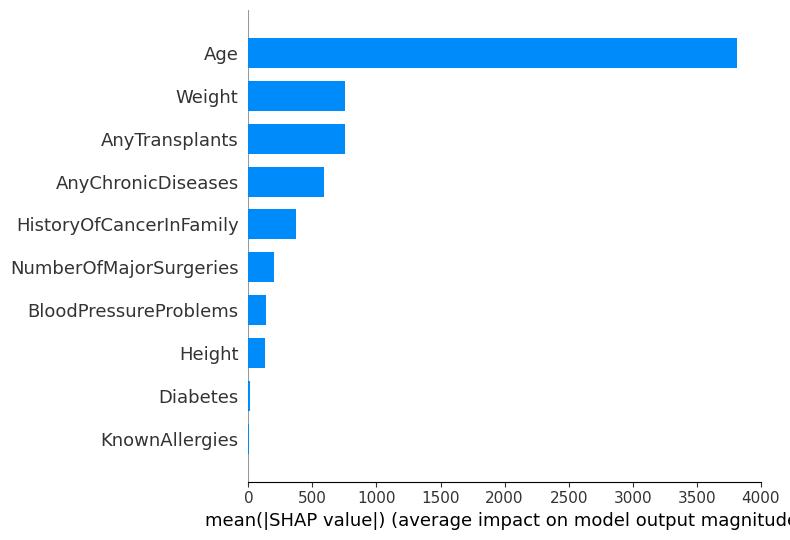

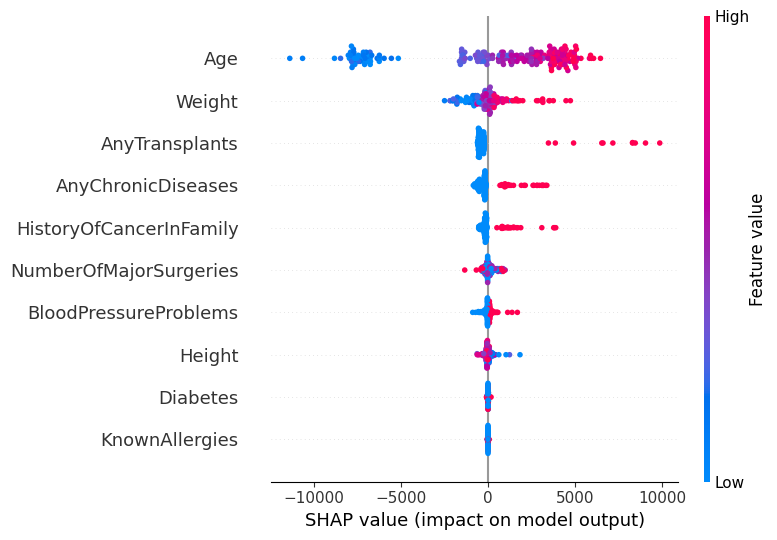

In [20]:
# Initialize the SHAP explainer based on your model
explainer = shap.TreeExplainer(model)  # This works well with tree-based models
shap_values = explainer.shap_values(X_test)

# Plot summary of feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")  # bar plot for overall feature importance
shap.summary_plot(shap_values, X_test)  # summary plot for distribution

#### Insights

- **Key Predictors**: Age, Transplants, Weight, and Chronic Diseases are significant in determining premiums. These features could be prioritized in feature engineering and model refinement.

- **Potential Redundant Features**: Height, Known Allergies, and Diabetes appear to have little influence on predictions and may even be candidates for removal to simplify the model.

- **Model Improvement**: Testing new models or tuning hyperparameters further might improve prediction reliability, especially focusing on Age and health-related indicators (e.g., chronic diseases and transplants), which appear essential for accurate premium prediction.